## Data processing

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('SeoulBikeData.csv',sep=',') 
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%d.%m.%Y')
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['dayofyear'] = pd.DatetimeIndex(df['Date']).dayofyear
df['weekofyear'] = pd.DatetimeIndex(df['Date']).weekofyear
df['weekday'] = pd.DatetimeIndex(df['Date']).weekday
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['is_month_start'] = pd.DatetimeIndex(df['Date']).is_month_start
df['is_month_end'] = pd.DatetimeIndex(df['Date']).is_month_end
df = df.drop(['Date'], axis = 1) 


Here we tranforme the first column which is the information about date on string.
So we first use pandas to convert this into a readble datetime format data, then
we divide 'date' into many smaller and more precise colunm: year,month,day,is_month_start etc...

In [3]:
df = pd.get_dummies(df, columns=['year'], drop_first=True, prefix='year')
df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='month')
df = pd.get_dummies(df, columns=['Seasons'], drop_first=True, prefix='season')
df = pd.get_dummies(df, columns=['Holiday'], drop_first=True, prefix='holiday')
df = pd.get_dummies(df, columns=['Functioning Day'], drop_first=True, prefix='fctday')
df = pd.get_dummies(df, columns=['weekday'], drop_first=True, prefix='wday')
df = pd.get_dummies(df, columns=['quarter'], drop_first=True, prefix='qrtr')
df = pd.get_dummies(df, columns=['is_month_start'], drop_first=True, prefix='m_start')
df = pd.get_dummies(df, columns=['is_month_end'], drop_first=True, prefix='m_end')

Here we use get_dummies from pandas library to convert no integer data into a int format usebale for machine learning models.
(We cannot just replace string by int manually, for example transfort spring summer fall winter into 0 1 2 3 will be an error because those numeric numbers have a mathmatical sens: 3 is 3 timese bigger than 1, 1 + 2 = 3 etc... )



In [4]:
X = df.drop(['Rented Bike Count'], axis = 1) 
Y = df['Rented Bike Count']

And now we split the original dataset into X and Y, and we are now looking for machine learning models f that will predict Y with X: Y = f(X)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=1)

We split our data with a methode implemented in sklearn with random_state parameter

In [20]:
from sklearn import preprocessing

ss_x = preprocessing.StandardScaler()
X_train_st = ss_x.fit_transform(X_train)
X_test_st = ss_x.transform(X_test)
 
ss_y = preprocessing.StandardScaler()
Y_train_st = ss_y.fit_transform(Y_train.values.reshape(-1, 1))
Y_test_st = ss_y.transform(Y_test.values.reshape(-1, 1))

Data processing will accelerate the GridSearch process

## KNN

In [66]:
from sklearn.model_selection import GridSearchCV

In [68]:
from sklearn.neighbors import KNeighborsRegressor
def findBestParametersKNN():
    model_KNN_GridSearch = KNeighborsRegressor()
    parameters_grid= {'n_neighbors':range(16),
                     'weights': ['uniform','distance'],
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    model=GridSearchCV(model_KNN_GridSearch,param_grid=parameters_grid,cv=5,n_jobs=7)
    model.fit(X_train_st,Y_train_st.ravel())
    print('model.best_score_:: ',model.best_score_)
    print('model.best_params_::  ',model.best_params_)
    print('best on test set：{:.3f}'.format(model.score(X_test_st,Y_test_st.ravel())))
findBestParametersKNN()

model.best_score_::  0.7427327637085913
model.best_params_::   {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
best on test set：0.765


Now lets finally get started with our prediction process, we first choose the KNN model, because it's very basic, simple and easily explainable, we obtained the best parameters with GridSearch, which k = 3 (very usual value).

In [70]:
def kNNPrediction():
    regressor = KNeighborsRegressor(algorithm = 'auto', 
                                    n_neighbors = 3,
                                    weights = 'distance')
    regressor.fit(X_train,Y_train.ravel())
    Y_pred = regressor.predict(X_test)
    return Y_pred
KNN_Predict = kNNPrediction()

We now have predictions from KNN model, let's take a look by ploting it on a graph

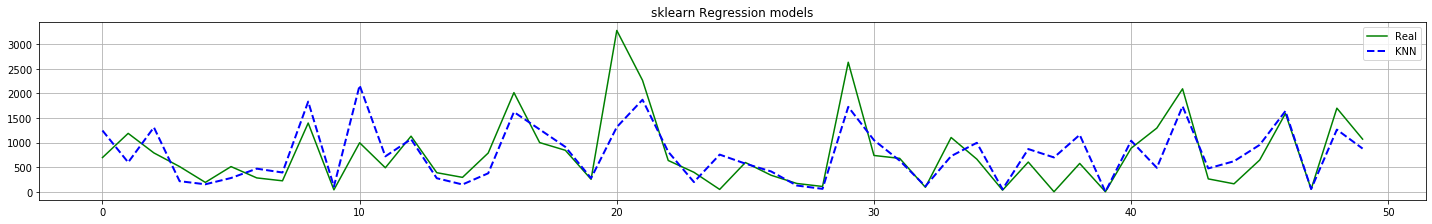

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 3))  
axes = fig.add_subplot(1, 1, 1)
line1,=axes.plot(range(50), [Y_test.values[i] for i in range(50)], 'g',label='Real')
line2,=axes.plot(range(50), [KNN_Predict[i] for i in range(50)] , 'b--',label='KNN',linewidth=2)
axes.grid()
fig.tight_layout()
plt.legend(handles=[line1, line2],loc = 'upper right')
plt.title('sklearn Regression models')
plt.show()

Because of the size of our dataset, we only compared 50 original values (to see more details) with predicted value from KNN.
With a precision of 0.765, the predictions of a simple model like KNN are globally interpretable.   

Now let's try a more complex model, the famous Random Forest and see if we will get more accurate predictions.

## RandomForest

In [67]:
from sklearn.ensemble import RandomForestRegressor
def findBestParametersRF():
    model_RF_GridSearch = RandomForestRegressor(random_state=2)
    parameters_grid= {'n_estimators':range(20,81,10),
                "min_samples_split" : [2,4,8],
                "min_samples_leaf" : [1,2,3],
                "max_features": ["auto", "sqrt", "log2"]}
    model=GridSearchCV(model_RF_GridSearch,param_grid=parameters_grid,cv=5,n_jobs=7)
    model.fit(X_train_st,Y_train_st.ravel())
    print('model.best_score_:: ',model.best_score_)
    print('model.best_params_::  ',model.best_params_)
    print('best on test set：{:.3f}'.format(model.score(X_test_st,Y_test_st.ravel())))
findBestParametersRF()

model.best_score_::  0.9228589670570972
model.best_params_::   {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
best on test set：0.922


We Secondly choosed the RandomForest model which is very stable and has the power of handle large data sets with higher dimensionality, despite his training time a bit too long.

The methode GridSearchCV has been used here to find the best parameters of this RandomForest model, we putted an interval of 
hyperparameters to select: 

n_estimators = number of trees in the foreset. If it's too small, the model could be underfitted, if it's too high it could be                overfitted, the time complexity will be too big, and the model performance increase will be too small, so we                    take a value around the default value.  

max_depth = default, because our dataset is not that big, we can let it be default and dont really need to worry about to much time cost.  

min_samples_split = min number of data points placed in a node before the node is split  
min_samples_leaf = min number of data points allowed in a leaf node  
max_features = max number of features considered for splitting a node  

In this methode i put n_jobs = 7 to mobilize 7 cores of my cpu (AMD 3700X which has 8 cores) to accelerate the calcul time.


In [42]:
def randomForestPrediction():
    regressor = RandomForestRegressor(max_features = 'auto', 
                                      min_samples_leaf = 1, 
                                      min_samples_split = 2, 
                                      n_estimators = 800,
                                      random_state=2)
    regressor.fit(X_train,Y_train.ravel())
    Y_pred = regressor.predict(X_test)
    return Y_pred
RF_Predict = randomForestPrediction()

We now have predictions of the Random Forest model, let's visualize it by plotting it on a graph compare to the previous KNN predictions.

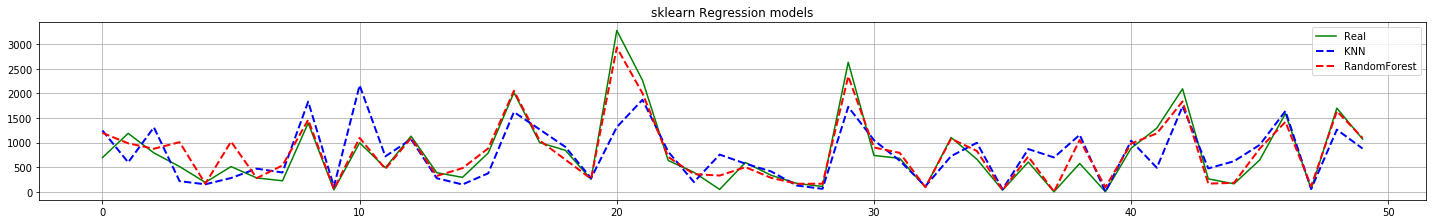

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 3))  
axes = fig.add_subplot(1, 1, 1)
line1,=axes.plot(range(50), [Y_test.values[i] for i in range(50)], 'g',label='Real')
line2,=axes.plot(range(50), [KNN_Predict[i] for i in range(50)] , 'b--',label='KNN',linewidth=2)
line3,=axes.plot(range(50), [RF_Predict[i] for i in range(50)] , 'r--',label='RandomForest',linewidth=2)
axes.grid()
fig.tight_layout()
plt.legend(handles=[line1, line2,line3],loc = 'upper right')
plt.title('sklearn Regression models')
plt.show()

That's much better, we can see on the graph the red line representing the RandomForest model is very close to the green line symbolizing the real data, compare to the blue line which is the predictions of KNN model.   

Now let's see another ensemble model of sklearn: GBDT,　Gradient Boosting Decision Tree.

## GradientBoosting

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
def findBestParametersGBDT():
    model_gbr_GridSearch=GradientBoostingRegressor(random_state=2)
    param_grid = {'n_estimators':range(20,81,10),
                  'learning_rate': [0.2,0.1, 0.05, 0.02, 0.01 ],
                  'max_depth': [4, 6,8],
                  'min_samples_leaf': [3, 5, 9, 14],
                  'max_features': [0.8,0.5,0.3, 0.1]}
    model = GridSearchCV(model_gbr_GridSearch,param_grid,cv=5,n_jobs=7)
    model.fit(X_train_st,Y_train_st.ravel() )
    print('model.best_score_:: ',model.best_score_)
    print('model.best_params_::  ',model.best_params_)
    print('best on test set：{:.3f}'.format(model.score(X_test_st,Y_test_st.ravel())))
findBestParametersGBDT()

model.best_score_::  0.9437364312863863
model.best_params_::   {'learning_rate': 0.2, 'max_depth': 8, 'max_features': 0.8, 'min_samples_leaf': 9, 'n_estimators': 80}
best on test set：0.938


Now we have the optimised model, we can calcul our prediction

In [75]:
def GBRPrediction():
    regressor = GradientBoostingRegressor(learning_rate = 0.2, 
                                          max_depth = 8, 
                                          max_features = 0.8, 
                                          min_samples_leaf = 9, 
                                          n_estimators = 80)
    regressor.fit(X_train,Y_train.ravel())
    Y_pred = regressor.predict(X_test)
    return Y_pred
GBR_Predict = GBRPrediction()

Now we can add the new prediction on previous graph

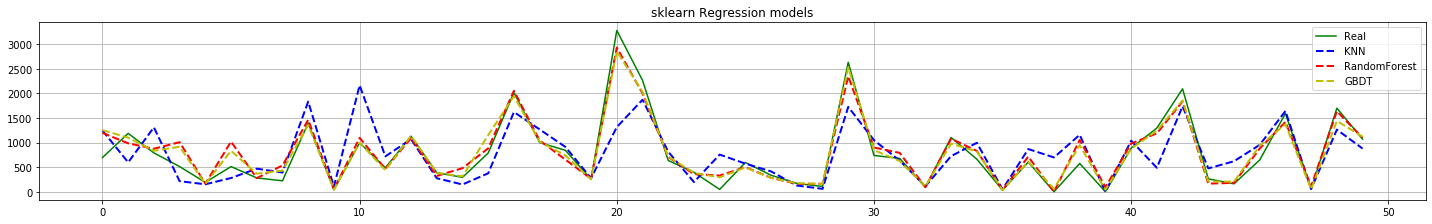

In [78]:
fig = plt.figure(figsize=(20, 3))  
axes = fig.add_subplot(1, 1, 1)
line1,=axes.plot(range(50), [Y_test.values[i] for i in range(50)], 'g',label='Real')
line2,=axes.plot(range(50), [KNN_Predict[i] for i in range(50)] , 'b--',label='KNN',linewidth=2)
line3,=axes.plot(range(50), [RF_Predict[i] for i in range(50)] , 'r--',label='RandomForest',linewidth=2)
line4,=axes.plot(range(50), [GBR_Predict[i] for i in range(50)], 'y--',label='GBDT',linewidth=2)
axes.grid()
fig.tight_layout()
plt.legend(handles=[line1, line2,line3,line4],loc = 'upper right')
plt.title('sklearn Regression models')
plt.show()

We can see that on the 50 first predictions, GBDT and RandomForest's predictions are very close from each other, it is consistent with the score on GridSearch test set with cross validation cv = 5: 0.922 and 0.938.  

RandomForest and Gradient Boosting are definitely better than KNN, but these two are very close in terms of prediction performance, with a slight advantage on the side of Gradient Boosting.  

But the RandomForest model has much less training time than the Gradient Boosting method, so the choice between these two will be based on that according to the different situation: in case of lack of time, we will favor the Random Forest method, otherwise we prefer to use the Gradient Boosting model.